Įvadas

Šioje duomenų bazėje yra skirtingi vynai iš JAV vyno parduotuvių ir jo parametrai - vyninė, šalis, regionas, skonis, kaina. Taip pat visi šie vynai yra vertinti 19 skirtingų vyno degustuotojų ir vertinti 100 balų sistemoje.

Darbo tikslas - apžiūrėti turimus vyno parametrus, taip pat sumodeliuoti kainų paskaičiamo modelį naudojant logistins regresijos modelį.

In [199]:
# Data from: https://www.kaggle.com/zynicide/wine-reviews

In [200]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

In [201]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression


from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report, mean_squared_error

In [202]:
wine_data = pd.read_csv('wine.csv')

In [203]:
print(f'Duomenų bazėjė yra {wine_data.shape[0]} eilučių ir {wine_data.shape[1]} stulpelių.')

Duomenų bazėjė yra 129971 eilučių ir 14 stulpelių.


In [204]:
wine_data.head(2)

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos


In [205]:
wine_data.columns

Index(['Unnamed: 0', 'country', 'description', 'designation', 'points',
       'price', 'province', 'region_1', 'region_2', 'taster_name',
       'taster_twitter_handle', 'title', 'variety', 'winery'],
      dtype='object')

Duomenų bazėje esantys stulpeliai 'Unnamed: 0', 'description', 'taster_twitter_handle' nebus naudojami duomenų analizėje, todėl jie yra pašalinami.

In [206]:
wine_data.drop(['Unnamed: 0', 'description', 'taster_twitter_handle'], axis=1, inplace=True)

In [207]:
# Let's check what kind of columns are in the data frame
wine_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129971 entries, 0 to 129970
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   country      129908 non-null  object 
 1   designation  92506 non-null   object 
 2   points       129971 non-null  int64  
 3   price        120975 non-null  float64
 4   province     129908 non-null  object 
 5   region_1     108724 non-null  object 
 6   region_2     50511 non-null   object 
 7   taster_name  103727 non-null  object 
 8   title        129971 non-null  object 
 9   variety      129970 non-null  object 
 10  winery       129971 non-null  object 
dtypes: float64(1), int64(1), object(9)
memory usage: 10.9+ MB


In [208]:
title = wine_data['title'].nunique()
variety = wine_data['variety'].nunique()
winery = wine_data['winery'].nunique()
country = wine_data['country'].nunique()
taster_name = wine_data['taster_name'].nunique()

print(f'Šioje duomenų bazėje turime {title} skirtingus vynus ({variety} skirtingų vyno rūšių), ne mažiau \nnei {winery} gamintojus iš ne mažiau kaip {country} šalių, vyną vertino bent {taster_name} vyno žinovai.')


Šioje duomenų bazėje turime 118840 skirtingus vynus (707 skirtingų vyno rūšių), ne mažiau 
nei 16757 gamintojus iš ne mažiau kaip 43 šalių, vyną vertino bent 19 vyno žinovai.


In [209]:
#Žemiau pažiūrime kokių duomenų duomenų lentelėje trūksta.
wine_data.isnull().sum()

country           63
designation    37465
points             0
price           8996
province          63
region_1       21247
region_2       79460
taster_name    26244
title              0
variety            1
winery             0
dtype: int64

Labai daug duomenų nėra designation, region_2 ir region 1. Dažnai sakoma, kad vyno pridetinė vertę nusako būtent šie parametrai, kurie yra kokybės kriterijus, vėliau darbe bus patikrintas šio kriterijaus svarba kokybei ar kainai.

Labai daug eilučių be kainos. Patikrinkime ar yra eilučiu, kur produkto kaina yra žinoma (ji yra kitoje eiluteje) ir užpildykime ten kur galime (vidutinę individualaus vyno kainą). 

In [210]:
# Žemiau esančiose eilutėse yra sukuriamos du duomenų setai - su kaina ir be kainos. Taip pat yra paskaičiuojame vidutinė 
# kiekvieno vyno kaina ir pridedama prie tų eilučių, kuriuose kainos nėra. Tada perkeliami iš duomenų seto be kainos į 
# duomenų setą su kaina

wine_data_full = wine_data
wine_wt_price = wine_data[wine_data['price'].isna()]
wine_data = wine_data[wine_data['price'].notna()]
price_avg = pd.DataFrame(wine_data.groupby('title').price.mean())
wine_wt_price = wine_wt_price.merge(price_avg, on = 'title', how = "left")
wine_wt_price['price_x'] = wine_wt_price['price_y']
wine_wt_price = wine_wt_price.iloc[:, :-1]
get_price = wine_wt_price[wine_wt_price['price_x'].notna()]
wine_data =  wine_data.append(get_price)
wine_wt_price = wine_wt_price[wine_wt_price['price_x'].isna()]  #wine_wt_price - vieta kuriame bus laikomos prekes be kainos.
wine_wt_price = wine_wt_price.iloc[:, :-1]

In [211]:
wine_data = wine_data.iloc[:, :-1]
wine_data.head()

,country,designation,points,price,province,region_1,region_2,taster_name,title,variety,winery
1,Portugal,Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks
5,Spain,Ars In Vitro,87,15.0,Northern Spain,Navarra,NaN,Michael Schachner,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem


In [212]:
# Peržiūrime bendrus duomenis

wine_data.describe()

,points,price
count,121115.000000,120975.000000
mean,88.421996,35.363389
std,3.044286,41.022218
min,80.000000,4.000000
25%,86.000000,17.000000
50%,88.000000,25.000000
75%,91.000000,42.000000
max,100.000000,3300.000000


Vynų kaina svyruoja nuo 4 dolerių iki 3300 dolerių - skirtumas labai yra didelis, todėl reikia įvertinti kaip tie vynai pasiskirstę. Taip pat pateikiami keli brangiausi ir pigiausi vynai (kainuojantis 4 dolerius).

In [213]:
wine_top_price = wine_data[['title', 'country', 'winery', 'variety', 'points', 'price']]
bottom_price = wine_top_price.sort_values(by = 'price')
top_price = wine_top_price.sort_values(by = 'price', ascending = False)

In [214]:
top_price = top_price.iloc[:5, :]

In [215]:
top_price.head()
# Brangiausi 4 vynai:

,title,country,winery,variety,points,price
80290,Château les Ormes Sorbet 2013 Médoc,France,Château les Ormes Sorbet,Bordeaux-style Red Blend,88,3300.0
15840,Château Pétrus 2014 Pomerol,France,Château Pétrus,Bordeaux-style Red Blend,96,2500.0
98380,Domaine du Comte Liger-Belair 2010 La Romanée,France,Domaine du Comte Liger-Belair,Pinot Noir,96,2500.0
120391,Blair 2013 Roger Rose Vineyard Chardonnay (Arr...,US,Blair,Chardonnay,91,2013.0
113564,Domaine du Comte Liger-Belair 2005 La Romanée,France,Domaine du Comte Liger-Belair,Pinot Noir,96,2000.0


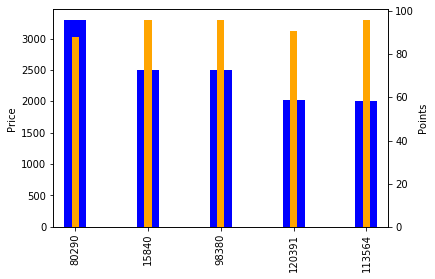

In [216]:
# Pažiūrėkime kokie vynai geriausi ir kaip jie vertinti grafike (mėlyna spalva - kaina, raudona - vertinimas).
fig = plt.figure(111) 

ax = fig.add_subplot()
ax2 = ax.twinx()

top_price.price.plot.bar(color='blue', ax=ax, width=0.3, position=1, align = 'edge')
top_price.points.plot.bar(color='orange', ax=ax2, width=0.1, position=1, align = 'edge')

ax.set_ylabel('Price')
ax2.set_ylabel('Points')

plt.show()

In [217]:
bottom_price[bottom_price['price'] == 4]
# Pigiausi vynai

,title,country,winery,variety,points,price
20484,Dancing Coyote 2015 White (Clarksburg),US,Dancing Coyote,White Blend,85,4.0
112919,Terrenal 2010 Estate Bottled Tempranillo (Yecla),Spain,Terrenal,Tempranillo,84,4.0
59507,Pam's Cuties NV Unoaked Chardonnay (California),US,Pam's Cuties,Chardonnay,83,4.0
31530,Bandit NV Chardonnay (California),US,Bandit,Chardonnay,84,4.0
61768,Terrenal 2010 Cabernet Sauvignon (Yecla),Spain,Terrenal,Cabernet Sauvignon,84,4.0
1987,Felix Solis 2013 Flirty Bird Syrah (Vino de la...,Spain,Felix Solis,Syrah,85,4.0
126096,Cramele Recas 2011 UnWineD Pinot Grigio (Viile...,Romania,Cramele Recas,Pinot Grigio,86,4.0
64590,Bandit NV Merlot (California),US,Bandit,Merlot,86,4.0
117303,Felix Solis 2012 Flirty Bird White (Vino de la...,Spain,Felix Solis,White Blend,82,4.0
29553,Broke Ass 2009 Red Malbec-Syrah (Mendoza),Argentina,Broke Ass,Malbec-Syrah,84,4.0


Text(0.5, 0.98, 'Vyno pasiskirstymas pagal kainas')

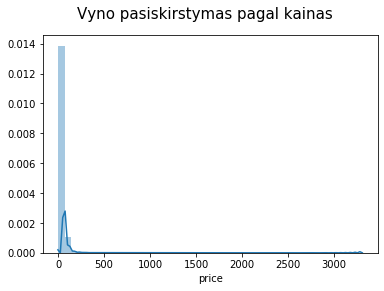

In [218]:
# Vynų kainų pasiskirstymas.

sns.distplot(wine_data['price'])
plt.suptitle('Vyno pasiskirstymas pagal kainas', fontsize=15)

Text(0.5, 0.98, 'Vyno pasiskirstymas pagal kainas')

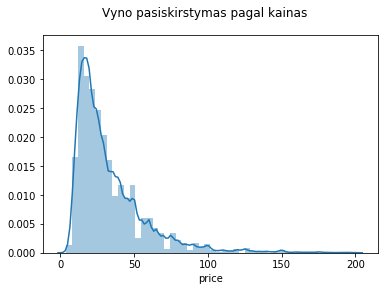

In [219]:
# Kaip matome iš viršuje esančio grafiko, vynai, brangesni nei 200-300 dolerių sudaro labai mažą dalį 
# visų vynų, jie yra visiškai išsiskiriantys ir nėra svarbūs mūsų analizei. Todėl tyrime toliau naudosime
# tik tuos vynus, kurie kainuoja mažiau nei 200 dolerių.

wine_data = wine_data[wine_data['price'] < 200]
sns.distplot(wine_data['price'])
plt.suptitle('Vyno pasiskirstymas pagal kainas', fontsize=12)

Text(0.5, 0.98, 'Vyno pasiskirstymas pagal kainas')

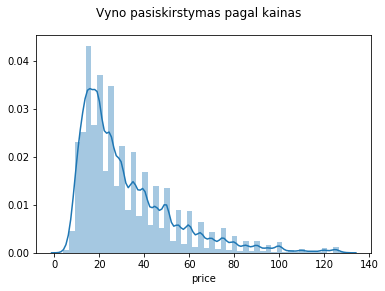

In [220]:
# Iš viršuje esančio grafiko matyti, kad net ir 200 dolerių kaina yra per didelė, tikslinga ją mažinti iki 130 dolerių.

wine_data = wine_data[wine_data['price'] < 130]
sns.distplot(wine_data['price'])
plt.suptitle('Vyno pasiskirstymas pagal kainas', fontsize=12)

Pažiūrėkime kokie vertinimai yra dažniausi.

Text(0.5, 0.98, 'Vyno pasiskirstymas pagal vertinimą')

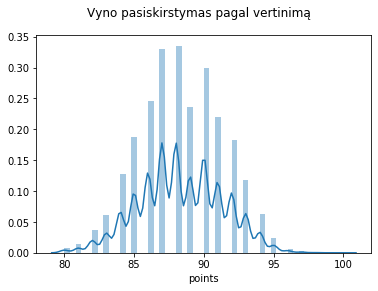

In [221]:
sns.distplot(wine_data['points'])
plt.suptitle('Vyno pasiskirstymas pagal vertinimą', fontsize=12)

In [222]:
def group_points(p):
    if p < 85:
        return 'Between 80 and 85'
    elif p < 90:
        return 'Between 85 and 90'
    elif p < 95:
        return 'Between 90 and 95'
    else:
        return 'Over 95'

wine_data["points_group"] = wine_data.points.apply(group_points)
wine_data.head(1)

,country,designation,points,price,province,region_1,region_2,taster_name,title,variety,winery,points_group
1,Portugal,Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,Between 85 and 90


In [223]:
wine_data['points_group'].unique()

array(['Between 85 and 90', 'Between 90 and 95', 'Between 80 and 85',
       'Over 95'], dtype=object)

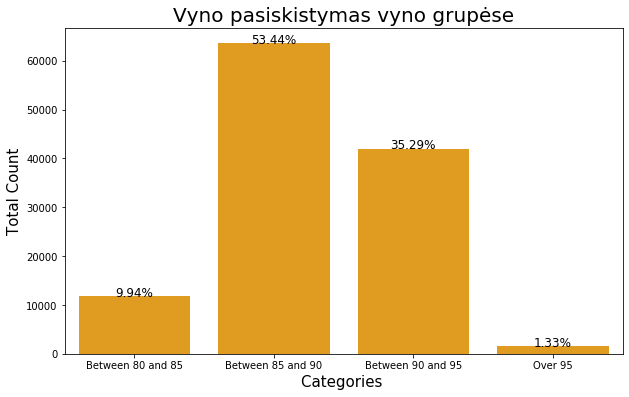

In [224]:
total = len(wine_data)
plt.figure(figsize=(10,6))

test = wine_data.points_group.value_counts().reset_index().sort_values('index')

order_ = ['Between 85 and 90', 'Between 90 and 95', 'Between 80 and 85',
       'Over 95']

g = sns.barplot(x='index', y='points_group', color='orange',
                  data=test)
g.set_title("Vyno pasiskistymas vyno grupėse", fontsize=20)
g.set_xlabel("Categories ", fontsize=15)
g.set_ylabel("Total Count", fontsize=15)

sizes=[]

for p in g.patches:
    height = p.get_height()
    sizes.append(height)
    g.text(p.get_x()+p.get_width()/2,
            height + 1,
            '{:1.2f}%'.format((height/total)*100),
            ha="center", fontsize=12) 

# g.set_ylim(0, max(sizes) * 0,9)

plt.show()

# Kaip susortuoti pagal kateorijas, o ne pagal reiksmes?


C:\Users\Gurmano\anaconda3\lib\site-packages\seaborn\distributions.py:693: UserWarning: Passing a 2D dataset for a bivariate plot is deprecated in favor of kdeplot(x, y), and it will cause an error in future versions. Please update your code.
  warnings.warn(warn_msg, UserWarning)


Text(0.5, 0.98, 'Vynų išsidėstymas vertinant kainas ir vertinimą')

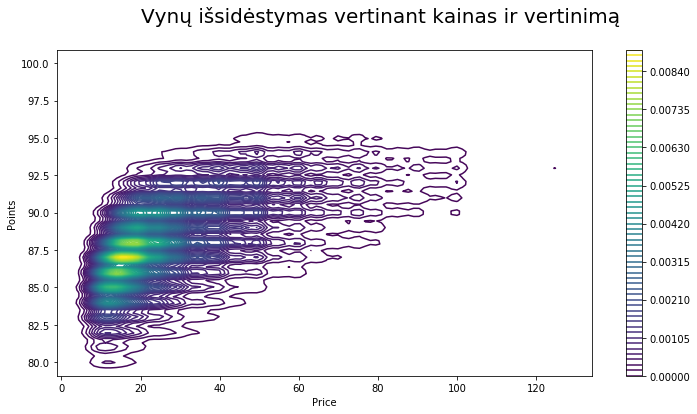

In [225]:
# Kainų ir vertinimo pasiskirstymas:

plt.figure(figsize=(12,6))
sns.kdeplot(wine_data.loc[:, ['price', 'points']], n_levels=60, cmap="viridis", cbar=True)
plt.xlabel('Price') 
plt.ylabel('Points')
plt.suptitle('Vynų išsidėstymas vertinant kainas ir vertinimą', fontsize=20)

Kaip matome iš viršuje esančio grafiko, labai didelis pasiskirtymas yra kainų invervale 87,5 - 90. Nors vertinimai labai panašūs, o kaina gali skirtis daugiau nei 8 kartus.

In [226]:
# Įvertinkime kokios rušies vynai yra popoliariausi tarp vertintojų
wine_variety = pd.DataFrame(wine_data.variety.value_counts().rename_axis('Wine_grape').reset_index(name='Wine_quantity'))
wine_variety.head(10)

,Wine_grape,Wine_quantity
0,Pinot Noir,12549
1,Chardonnay,10933
2,Cabernet Sauvignon,8976
3,Red Blend,8340
4,Bordeaux-style Red Blend,5112
5,Riesling,4902
6,Sauvignon Blanc,4782
7,Syrah,4045
8,Rosé,3260
9,Merlot,3036


C:\Users\Gurmano\anaconda3\lib\site-packages\seaborn\distributions.py:693: UserWarning: Passing a 2D dataset for a bivariate plot is deprecated in favor of kdeplot(x, y), and it will cause an error in future versions. Please update your code.
  warnings.warn(warn_msg, UserWarning)


Text(0.5, 0.98, 'Vynų išsidėstymas vertinant kainas ir vertinimą')

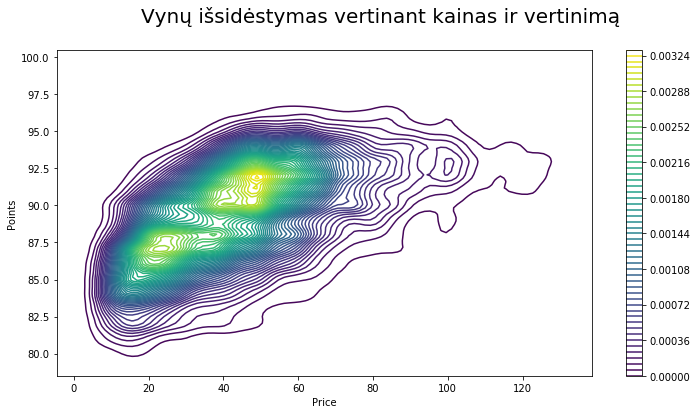

In [227]:
# Vyno "Pinot noir" pasiskirstymas pagal kainas ir taškus.
# pinot = wine_data[wine_data['variety'] == 'Pinot Noir']
plt.figure(figsize=(12,6))
sns.kdeplot(wine_data[wine_data['variety'] == 'Pinot Noir'].loc[:, ['price', 'points']], n_levels=60, cmap="viridis", cbar=True)
plt.xlabel('Price') 
plt.ylabel('Points')
plt.suptitle('Vynų išsidėstymas vertinant kainas ir vertinimą', fontsize=20)


In [228]:
#Žemiau kiekvienoje verteje pigiausias ir brangiausias vynas ir gamintojas "Pinot Noir" vynų grupėje.

def min_price(p):    
    return wine_data['price'][(wine_data['variety'] == 'Pinot Noir') & (wine_data['points'] == p)].min()

def max_price(p):
    return wine_data['price'][(wine_data['variety'] == 'Pinot Noir') & (wine_data['points'] == p)].max()

points_values = np.arange(80, 100)
name = ['points']


vertes = pd.DataFrame(data=points_values, columns=name)

vertes["max kaina"] =  vertes.points.apply(max_price)
vertes["min kaina"] =  vertes.points.apply(min_price)

def gamintojas(points, price):    
    return wine_data['winery'][(wine_data['variety'] == 'Pinot Noir') & 
                               (wine_data['points'] == points) & (wine_data['price'] == price)]    

i, z, w = [], [], []

for x in range(20):
    i.append(vertes.iloc[x]['points'])
    z.append(vertes.iloc[x]['max kaina'])
    w.append(vertes.iloc[x]['min kaina'])
    
gamint_max, gamint_min = [], []
for x in range(20):
    a = i[x]
    b = z[x]
    c = w[x]
    gamint_max.append(gamintojas(a, b).iloc[0])
    gamint_min.append(gamintojas(a, c).iloc[0])
    
vertes['max_price_winery'] = gamint_max
vertes['min_price_winery'] = gamint_min

In [229]:
vertes

,points,max kaina,min kaina,max_price_winery,min_price_winery
0,80,36.0,7.0,Bryter,Backhouse
1,81,62.0,7.0,Hunt Cellars,flipflop
2,82,69.0,7.0,Canihan,Camelot
3,83,75.0,5.0,Adrian Fog,French Rabbit
4,84,100.0,7.0,Torres,Morandé
5,85,75.0,7.0,Archery Summit,flipflop
6,86,100.0,7.0,Halleck,Cramele Recas
7,87,120.0,7.0,L. Tramier & Fils,Le Pépin
8,88,128.0,8.0,Domaine Jacques Prieur,Three Thieves
9,89,125.0,8.0,Jean Stodden,Woodbridge by Robert Mondavi


In [230]:
# Pažiūrėkime kaip vertinami ir kiek kainuoja vynai, kurie vertinti bent 4000 kartų (8 populiariausi)
# kaip filtruoti is listo?

top_wine_variety = list(wine_variety.iloc[:8, 0])
data_top_variety = wine_data[wine_data['variety'].isin(top_wine_variety)]

Text(0.5, 1.0, 'Points')

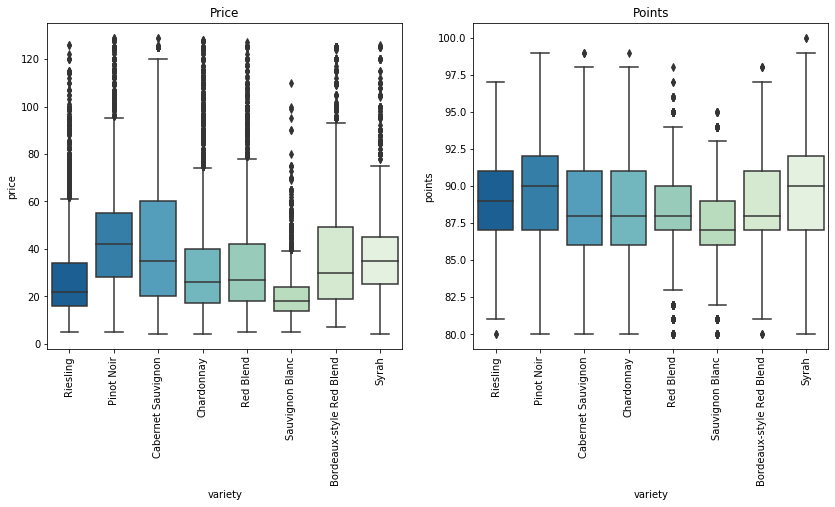

In [231]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
sns.boxplot(x='variety', y='price', palette='GnBu_r', data=data_top_variety)
plt.xticks(rotation=90)
plt.title('Price')

plt.subplot(1,2,2)
sns.boxplot(x='variety', y='points', palette='GnBu_r', data=data_top_variety)
plt.xticks(rotation=90)
plt.title('Points')

In [232]:
# Kaip matome iš grafiko viršuje, "Pinot noir" ir "Syrah" kokybiniuose vynuose išsiskiria, 
# tačiau jie yra salyginai pigesni nei kiti taip pat vertinami vynai. O labiausiai "permokamas vynas"
# yra "Cabernet Sauvignon" rušies. Patikrinkime bendrą kainos ir vertinimo koreliaciją bendrai ir kiekvienai
# rūšiai atskirai.

In [233]:
# Dugustuotų vynų populiariausios šalys

wine_country = pd.DataFrame(wine_data.country.value_counts().rename_axis('Wine_country').reset_index(name='Wine_quantity'))
wine_country.head(10)

,Wine_country,Wine_quantity
0,US,53685
1,France,17108
2,Italy,16536
3,Spain,6444
4,Portugal,4827
5,Chile,4395
6,Argentina,3723
7,Austria,2794
8,Australia,2243
9,Germany,2046


In [234]:
# Pažiūrėkime kaip vertinami ir kiek kainuoja vynai iš daugiausia vertintų 7 valstybių.

top_wine_country = list(wine_country.iloc[:7, 0])
data_top_country = wine_data[wine_data['country'].isin(top_wine_country)]

Text(0.5, 1.0, 'Points')

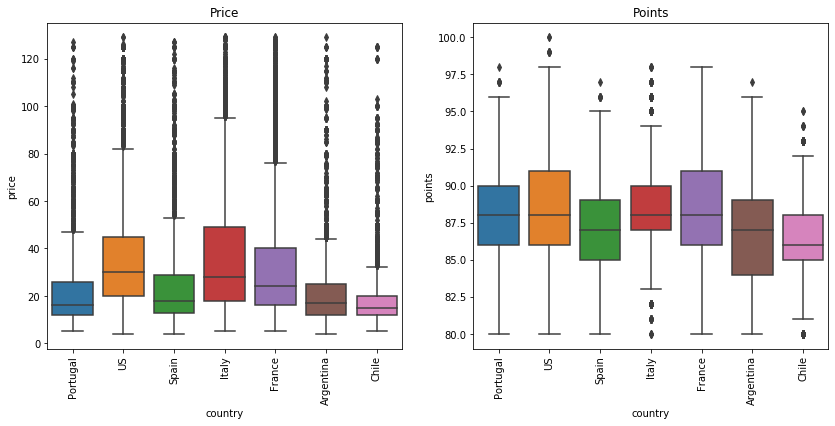

In [235]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
# sns.boxplot(x='country', y='price', palette='GnBu_r', data=data_top_country)
sns.boxplot(x='country', y='price', data=data_top_country)
plt.xticks(rotation=90)
plt.title('Price')

plt.subplot(1,2,2)
sns.boxplot(x='country', y='points', data=data_top_country)
plt.xticks(rotation=90)
plt.title('Points')

# sns.violinplot

Aukščiau esančioje lentelėje matome, kad itališki vynai yra brangesni, bet nėra taip gerai vertinami kaip kitų šalių vynai. Tuo tarpų prancūziškų vynų kokybė vertiname geriau nei kad jie kainuoja.


In [236]:
# Žemiau esančiame pažiūrėsime kaip kainas/kokybę įtakoja gamintojas.

In [237]:
wine_winery = pd.DataFrame(wine_data.winery.value_counts().rename_axis('winery').reset_index(name='Wine_quantity'))
wine_winery.head(10)

,winery,Wine_quantity
0,Testarossa,217
1,Williams Selyem,211
2,Wines & Winemakers,209
3,DFJ Vinhos,209
4,Chateau Ste. Michelle,193
5,Columbia Crest,158
6,Concha y Toro,156
7,Kendall-Jackson,130
8,Siduri,126
9,Gary Farrell,125


In [238]:
# Pažiūrėkime kaip vertinami ir kiek kainuoja vynai iš daugiausia vertintų 6 gamintojų.

top_wine_winery = list(wine_winery.iloc[:6, 0])
data_top_winery= wine_data[wine_data['winery'].isin(top_wine_winery)]
data_top_winery.head()

,country,designation,points,price,province,region_1,region_2,taster_name,title,variety,winery,points_group
145,US,Guidotti Vineyard,91,64.0,California,Santa Lucia Highlands,Central Coast,Matt Kettmann,Testarossa 2013 Guidotti Vineyard Pinot Noir (...,Pinot Noir,Testarossa,Between 90 and 95
235,US,Thompson Vineyard,85,49.0,California,Santa Barbara County,Central Coast,NaN,Testarossa 2006 Thompson Vineyard Syrah (Santa...,Syrah,Testarossa,Between 85 and 90
525,US,Rincon Vineyard,91,49.0,California,Arroyo Grande Valley,Central Coast,Matt Kettmann,Testarossa 2015 Rincon Vineyard Chardonnay (Ar...,Chardonnay,Testarossa,Between 90 and 95
684,US,Canoe Ridge Vineyard,90,30.0,Washington,Horse Heaven Hills,Columbia Valley,Sean P. Sullivan,Chateau Ste. Michelle 2012 Canoe Ridge Vineyar...,Cabernet Sauvignon,Chateau Ste. Michelle,Between 90 and 95
737,Portugal,Casa Ermelinda Freitas Monte de Baía,85,12.0,Península de Setúbal,NaN,NaN,Roger Voss,Wines & Winemakers 2015 Casa Ermelinda Freitas...,Rosé,Wines & Winemakers,Between 85 and 90


Text(0.5, 1.0, 'Points')

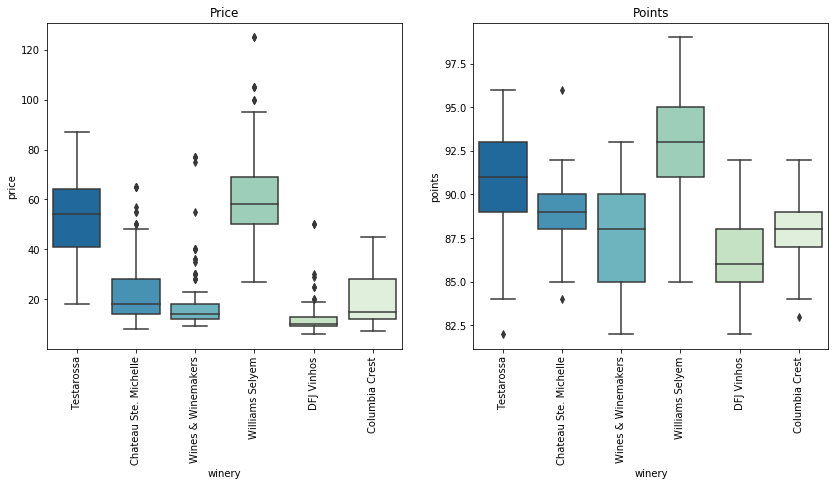

In [239]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
sns.boxplot(x='winery', y='price', palette='GnBu_r', data=data_top_winery)
plt.xticks(rotation=90)
plt.title('Price')

plt.subplot(1,2,2)
sns.boxplot(x='winery', y='points', palette='GnBu_r', data=data_top_winery)
plt.xticks(rotation=90)
plt.title('Points')

In [240]:
wine_data['region_1'].fillna('n', inplace=True)
wine_data['region_2'].fillna('n', inplace=True)
wine_data['country'].fillna('n', inplace=True)
wine_data['winery'].fillna('n', inplace=True)
wine_data['designation'].fillna('n', inplace=True)
wine_data['province'].fillna('n', inplace=True)
wine_data['variety'].fillna('n', inplace=True)

In [241]:
wine_data.head(2)

,country,designation,points,price,province,region_1,region_2,taster_name,title,variety,winery,points_group
1,Portugal,Avidagos,87,15.0,Douro,n,n,Roger Voss,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,Between 85 and 90
2,US,n,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,Between 85 and 90


In [242]:
from sklearn.preprocessing import LabelEncoder


reg1 = LabelEncoder()
reg2 = LabelEncoder()
country = LabelEncoder()
winery = LabelEncoder()
desig = LabelEncoder()
province = LabelEncoder()
variet = LabelEncoder()

reg1.fit(wine_data['region_1'])
reg2.fit(wine_data['region_2'])
country.fit(wine_data['country'])
winery.fit(wine_data['winery'])
desig.fit(wine_data['designation'])
province.fit(wine_data['province'])
variet.fit(wine_data['variety'])


wine_data['region_1'] = reg1.transform(wine_data['region_1'])
wine_data['region_2'] = reg2.transform(wine_data['region_2'])
wine_data['country'] = country.transform(wine_data['country'])
wine_data['winery'] = winery.transform(wine_data['winery'])
wine_data['designation'] = desig.transform(wine_data['designation'])
wine_data['province'] = province.transform(wine_data['province'])
wine_data['variety'] = variet.transform(wine_data['variety'])



In [243]:
wine_data.head()

,country,designation,points,price,province,region_1,region_2,taster_name,title,variety,winery,points_group
1,30,2187,87,15.0,107,1180,17,Roger Voss,Quinta dos Avidagos 2011 Avidagos Red (Douro),444,12112,Between 85 and 90
2,39,35069,87,14.0,266,1168,16,Paul Gregutt,Rainstorm 2013 Pinot Gris (Willamette Valley),430,12172,Between 85 and 90
3,39,25758,87,13.0,216,520,17,Alexander Peartree,St. Julian 2013 Reserve Late Harvest Riesling ...,472,13486,Between 85 and 90
4,39,33706,87,65.0,266,1168,16,Paul Gregutt,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,434,13712,Between 85 and 90
5,36,1867,87,15.0,260,716,17,Michael Schachner,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,579,13792,Between 85 and 90


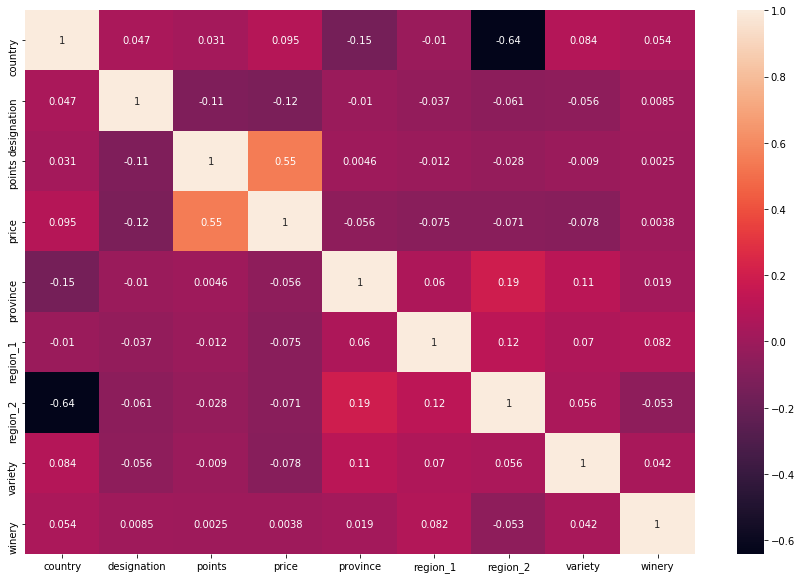

In [244]:
plt.figure(figsize=(15, 10))
sns.heatmap(wine_data.corr(), annot=True)

Kaip matome iš viršutinio modelio koreliacija yra tik vertinimo ir kainos, bet ji nėra labai didelė. Pamėginkime paskaičiuoti koreliacija paėmę tik top 6 vynines. 

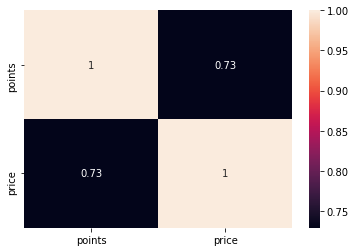

In [245]:
plt.figure(figsize=(6, 4))
sns.heatmap(data_top_winery.corr(), annot=True)

In [246]:
data_top_winery.head(1)

,country,designation,points,price,province,region_1,region_2,taster_name,title,variety,winery,points_group
145,US,Guidotti Vineyard,91,64.0,California,Santa Lucia Highlands,Central Coast,Matt Kettmann,Testarossa 2013 Guidotti Vineyard Pinot Noir (...,Pinot Noir,Testarossa,Between 90 and 95


In [247]:
winery = LabelEncoder()
winery.fit(data_top_winery['winery'])
data_top_winery['winery'] = winery.transform(data_top_winery['winery'])

C:\Users\Gurmano\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [248]:
data_top_winery.columns

Index(['country', 'designation', 'points', 'price', 'province', 'region_1',
       'region_2', 'taster_name', 'title', 'variety', 'winery',
       'points_group'],
      dtype='object')

In [249]:
data_top_winery.drop(['country', 'designation', 'province', 'region_1',
       'region_2', 'taster_name', 'variety', 'points_group'], axis=1, inplace=True)

C:\Users\Gurmano\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [250]:
data_top_winery.columns

Index(['points', 'price', 'title', 'winery'], dtype='object')

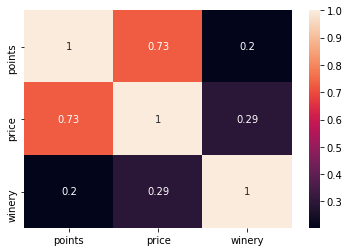

In [251]:
plt.figure(figsize=(6, 4))
sns.heatmap(data_top_winery.corr(), annot=True)

In [252]:
# feature_cols = ['points']
feature_cols = ['points', 'winery']


X = data_top_winery[feature_cols]
y = data_top_winery['price']

In [253]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [254]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=150, max_depth=4, class_weight='balanced')

In [255]:
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=4, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [256]:
predictions = rfc.predict(X_test)

In [257]:
kainu_nuokrypis = round(np.sqrt(mean_squared_error(y_test, predictions)), 2)

print(f'Kainos nuokrypis nuo paskaičiuotos kainos yra maždaug {kainu_nuokrypis} dolerio.')

Kainos nuokrypis nuo paskaičiuotos kainos yra maždaug 14.85 dolerio.


In [258]:
calculated_price = pd.Series(predictions, index = y_test.index)

In [259]:
wine_data['Calculated price'] = calculated_price

In [261]:
wine_data[wine_data['Calculated price'].notnull()]

,country,designation,points,price,province,region_1,region_2,taster_name,title,variety,winery,points_group,Calculated price
1113,39,14667,90,15.0,407,479,3,Sean P. Sullivan,Chateau Ste. Michelle 2013 Horse Heaven Vineya...,505,2720,Between 90 and 95,31.0
1241,39,35069,88,13.0,407,266,3,Paul Gregutt,Chateau Ste. Michelle 2007 Chardonnay (Columbi...,123,2720,Between 85 and 90,16.0
1893,39,14160,89,46.0,51,867,12,NaN,Williams Selyem 2005 Hawk Hill Vineyard Chardo...,123,15488,Between 85 and 90,37.0
2899,30,19117,86,12.0,7,1180,17,Roger Voss,Wines & Winemakers 2013 Lua Cheia em Vinhas Ve...,20,15535,Between 85 and 90,14.0
3945,30,6503,83,14.0,391,1180,17,Roger Voss,Wines & Winemakers 2010 Clemens Reserva White ...,447,15535,Between 80 and 85,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
128175,39,13525,86,12.0,407,266,3,Sean P. Sullivan,Columbia Crest 2015 Grand Estates Unoaked Char...,123,4602,Between 85 and 90,24.0
128593,30,7156,85,15.0,353,1180,17,Roger Voss,Wines & Winemakers 2015 Companhia das Lezirias...,447,15535,Between 85 and 90,14.0
128933,39,4160,89,41.0,51,186,1,NaN,Testarossa 2011 Brosseau Vineyard Chardonnay (...,123,14103,Between 85 and 90,41.0
129423,30,708,89,18.0,107,1180,17,Roger Voss,Wines & Winemakers 2016 Aguia Moura em Vinhas ...,447,15535,Between 85 and 90,19.0


Išvada: vertinti vynų kainos ir kokybės santykį itin sudėtinga, o gal ir ir iš viso neįmanoma. Žinant pardavimus, gamyklos pajėgumus, būtų galima vertinti atskiros gamyklos atskirų produktų kainas, tikrai yra gamintojų (pvz., prancūziški vynai), kurie galėtų kelti kainas, nes jų kainos "atsilieka" nuo kokybinių vertinimų. Tuo tarpu ispaniški vynai aiškiai yra pervertinti ir jie turėtų kainuoti pigiau.